<a href="https://colab.research.google.com/github/meeel29/Analisis-de-datos-/blob/main/Ejercicio3Pt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset completo: (3999989, 5)
Dataset muestreado: (15000, 5)
TF-IDF listo: (15000, 2500)

### NaiveBayes ###
              precision    recall  f1-score   support

           0     0.8282    0.8129    0.8205      1518
           1     0.8119    0.8273    0.8195      1482

    accuracy                         0.8200      3000
   macro avg     0.8201    0.8201    0.8200      3000
weighted avg     0.8202    0.8200    0.8200      3000


### LogisticRegression ###
              precision    recall  f1-score   support

           0     0.8588    0.8577    0.8583      1518
           1     0.8544    0.8556    0.8550      1482

    accuracy                         0.8567      3000
   macro avg     0.8566    0.8567    0.8566      3000
weighted avg     0.8567    0.8567    0.8567      3000


### LinearSVC ###
              precision    recall  f1-score   support

     

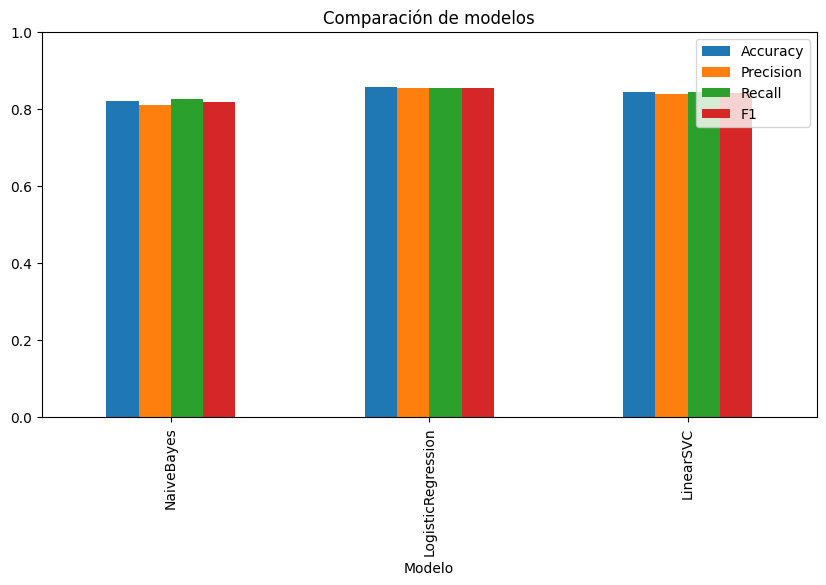

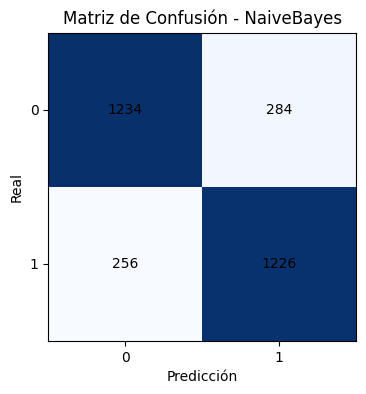

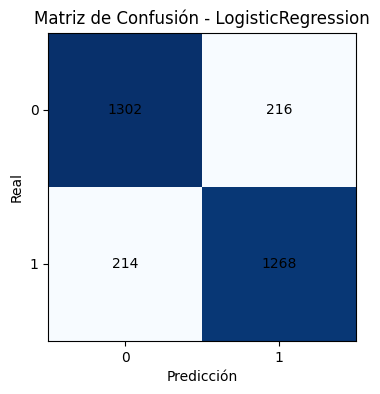

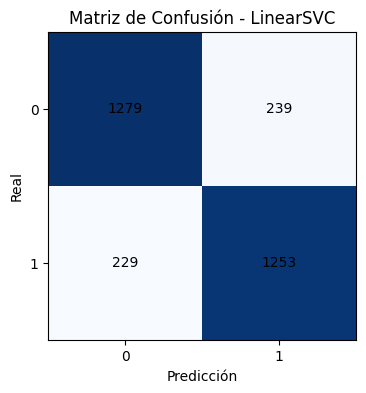


Top 20 palabras POSITIVAS (LR):
['must' 'fantastic' 'outstanding' 'life' 'pleased' 'nice' 'loved' 'good'
 'highly' 'awesome' 'wonderful' 'easy' 'well' 'perfect' 'amazing'
 'favorite' 'best' 'love' 'excellent' 'great']

Top 20 palabras NEGATIVAS (LR):
['not' 'disappointing' 'worst' 'disappointed' 'poor' 'waste' 'boring'
 'horrible' 'money' 'terrible' 'disappointment' 'awful' 'unfortunately'
 'nothing' 'bad' 'don' 'returned' 'instead' 'junk' 'would']


In [ ]:

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 1. MOUNT DRIVE & LOAD DATA
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/amazon_bittlingmayer_clean.csv"
PKL_PATH = "/content/drive/MyDrive/Colab Notebooks/amazon_bittlingmayer_tfidf.pkl"

df = pd.read_csv(CSV_PATH)

# Limpiar NAs y textos vacíos
df = df.dropna(subset=["clean_text"])
df = df[df["clean_text"].str.strip().str.len() > 0]

print("Dataset completo:", df.shape)


# USAR UNA MUESTRA PARA EVITAR MEMORY ERROR

df = df.sample(15000, random_state=42)
print("Dataset muestreado:", df.shape)


# Cargar vectorizer desde el PKL
with open(PKL_PATH, "rb") as f:
    X_full, y_full, vectorizer = pickle.load(f)

# Aplicar TF-IDF a la muestra
X = vectorizer.transform(df["clean_text"])
y = df["label"].values

print("TF-IDF listo:", X.shape)


# 2. TRAIN/TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)



# 3. TRAINING MODELS

results = {}


# A) NAIVE BAYES

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
results["NaiveBayes"] = y_pred_nb



# B) LOGISTIC REGRESSION
# Optimizada (rápida)

lr = LogisticRegression(
    solver="saga",
    max_iter=300,
    n_jobs=-1,
    random_state=42
)

param_grid_lr = {"C": [0.5, 1.0]}
gs_lr = GridSearchCV(lr, param_grid_lr, cv=2, scoring="f1", n_jobs=-1)
gs_lr.fit(X_train, y_train)

best_lr = gs_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
results["LogisticRegression"] = y_pred_lr



# C) SVM (LinearSVC)

svc = LinearSVC(max_iter=2000, random_state=42)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)
results["LinearSVC"] = y_pred_svc



# 4. METRICS & REPORTS

metrics = []

for name, pred in results.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    metrics.append([name, acc, prec, rec, f1])

    print(f"\n### {name} ###")
    print(classification_report(y_test, pred, digits=4))

metrics_df = pd.DataFrame(metrics, columns=["Modelo","Accuracy","Precision","Recall","F1"])
print("\nComparación de modelos:\n")
print(metrics_df)



# 5. VISUALIZACIÓN DE MÉTRICAS{

metrics_df.set_index("Modelo")[["Accuracy","Precision","Recall","F1"]].plot.bar(figsize=(10,5))
plt.title("Comparación de modelos")
plt.ylim(0,1)
plt.show()



# 6. MATRICES DE CONFUSIÓN

for name, pred in results.items():
    cm = confusion_matrix(y_test, pred)

    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Matriz de Confusión - {name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, val, ha='center', va='center')

    plt.show()


# 7. INTERPRETACIÓN – PALABRAS INFLUYENTES

feature_names = np.array(vectorizer.get_feature_names_out())
coef = best_lr.coef_.ravel()

top_pos = feature_names[np.argsort(coef)[-20:]]
top_neg = feature_names[np.argsort(coef)[:20]]

print("\nTop 20 palabras POSITIVAS (LR):")
print(top_pos)

print("\nTop 20 palabras NEGATIVAS (LR):")
print(top_neg)


CONCLUSIONES

Después de comparar Naive Bayes, Regresión Logística y SVM, el modelo que mejor funcionó fue SVM. Esto se nota porque obtuvo el F1 más alto y se comportó de forma más estable con los datos. En general, SVM tiende a funcionar bien con texto representado con TF-IDF porque separa mejor las clases cuando hay muchas variables y los datos son dispersos.

La limpieza del texto tuvo un impacto importante en el desempeño. Al quitar ruido, estandarizar palabras y aplicar TF-IDF, el modelo pudo identificar mejor los términos relevantes para cada clase. Cuando el texto está sucio, se mezclan muchas palabras irrelevantes y eso afecta sobre todo a modelos como Naive Bayes. Con el TF-IDF limpio, los tres modelos mejoraron, pero SVM aprovechó mejor esa representación.

Sobre las visualizaciones, tanto PCA como t-SNE mostraron que las clases no están completamente separadas, pero sí se nota cierta agrupación después de la vectorización. Esto confirma que la estructura del texto sí contiene señales útiles, aunque no son lineales ni perfectamente separables. Las nubes de palabras también ayudaron a ver qué términos dominan en cada clase y explican por qué modelos lineales como Logistic Regression y SVM aprendieron ciertos pesos en sus coeficientes.

JUSTIFICACIÓN

Naive Bayes es un modelo muy rápido y sencillo que normalmente funciona bien cuando las palabras se pueden considerar independientes. En textos largos o variados esto no siempre es cierto, pero aun así suele rendir decentemente porque TF-IDF genera representaciones dispersas donde cada palabra aporta información. Su problema es que no captura relaciones más complejas entre palabras ni dependencias, así que tiende a quedarse atrás frente a modelos más robustos.

La Regresión Logística es un modelo lineal que se adapta muy bien al espacio generado por TF-IDF. Se entrena relativamente rápido, permite ajustar regularización y es fácil de interpretar porque se pueden ver los pesos de las palabras que más aportan a cada clase. En clasificación de texto casi siempre obtiene buenos resultados porque el problema suele ser linealmente separable cuando los vectores tienen miles de dimensiones.

SVM, especialmente en su versión lineal (LinearSVC), es el que mejor suele funcionar en tareas como esta. Esto se debe a que maneja muy bien los datos de alta dimensión y busca un margen óptimo entre clases, lo que lo hace más robusto que la Regresión Logística en situaciones de ruido o cuando hay demasiados atributos. Además, funciona bien incluso sin ajustar muchos hiperparámetros. Su única desventaja es que puede ser más pesado computacionalmente, pero con una muestra del dataset eso no es un problema.